# Linear Gaussian example

The function is $y=\theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \epsilon = X \theta + \epsilon$. The NN is composed simply of 2 inputs and 1 output, no hidden layer, and a linear activation function. The data is $D = \lbrace X, y \rbrace=\lbrace x_{1}, x_{2}, y\rbrace$.

The prior is chosen to be Gaussian, $p(\theta) = N(\cdot, \theta_{prior}, \Sigma_{prior})  $, and so is the noise $\epsilon \sim N(\cdot; 0, \sigma_{n}^{2} I)$. Then the posterior of the parameters can be computed analytically as:

\begin{align*}
& p(\theta \vert D={x,y}) =  N(\cdot; \theta_{post}(D), \Sigma_{post}(D)) \\
& \theta_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1} \left(\frac{1}{\sigma_{n}^{2}}X^{T}y+\Sigma^{-1}\theta_{prior} \right) \\
& \Sigma_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1}
\end{align*}

In [3]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from UQ_in_ML.examples_utils import *
from scipy.stats import multivariate_normal

from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import *
from UQ_in_ML.epistemic_correctors import *

### Define some functions to compute the true posterior pdf from data, and some plotting utils

In [4]:
# compute the true posterior pdf based on available data
def compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n):
    X = np.concatenate([xn, np.ones((xn.shape[0], 1))], axis=1)
    
    # compute posterior pdf
    S_posterior = np.linalg.inv(1/var_n*np.matmul(X.T,X)+np.linalg.inv(S_prior))
    m_posterior = np.matmul(
        S_posterior, 
        1/var_n*np.matmul(X.T, yn)+np.matmul(np.linalg.inv(S_prior), m_prior.reshape((-1,1)))
        )
    m_posterior = m_posterior.reshape((-1,))
    return m_posterior, S_posterior

def compute_gaussian_pdf(x, mean, std):
    log2pi = np.log(2 * np.pi).astype(np.float32)
    return np.exp(- 0.5 * log2pi - np.log(std) - 0.5 * np.square(np.divide(np.subtract(x, mean), std)))

In [5]:
# plot the loss
def plot_loss(reg):
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(reg.loss_history)
    ax.set_xlabel('epochs'); ax.set_title('Loss convergence during training')
    plt.show(fig)

labels_params = [r'$W_{1}$', r'$W_{2}$', r'$b$']
# plot parameter learning
def plot_params_convergence(reg, m_posterior, S_posterior):
    fig, ax = plt.subplots(ncols=2, figsize=(13,4))
    for i in range(3):
        ax[0].plot(reg.variational_mu_history[:, i], label=labels_params[i]+', true={}'.format(m_posterior[i]))
        ax[1].plot(reg.variational_sigma_history[:, i], 
                   label=labels_params[i]+', true={}'.format(np.sqrt(np.diag(S_posterior)[i])))
    ax[0].set_title('posterior mean')
    ax[1].set_title('posterior std')
    ax[0].grid('on'); ax[1].grid('on'); 
    ax[0].legend(); ax[1].legend()
    plt.show(fig)
    
def plot_marginals(m_posterior, S_posterior, vi_regressor, corrector_weights):
    print('Marginal pdfs in all dimensions')
    fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
    for i in range(3):
        kwargs = {'color':'black', 'label':'true'}
        plot_univariate_pdf(mean=m_posterior[i], std=np.sqrt(S_posterior[i,i]), ax=ax[i], **kwargs)
        kwargs = {'color':'green', 'label':'VI regressor'}
        plot_univariate_pdf(mean=vi_regressor.variational_mu_history[-1, i], 
                            std=vi_regressor.variational_sigma_history[-1, i], 
                            ax=ax[i], **kwargs)
        kwargs = {'color':'red', 'label':'VI + correction'}
        plot_univariate_pdf(samples=corrector_weights[:, i], ax=ax[i], **kwargs)
    ax[0].legend()
    plt.show(fig)
    
# plot covariance and correlation matrices
def plot_corr(corrector_weights, S_posterior):
    print('Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)')
    fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
    plot_covariance_matrix(cov=cov_to_corr(S_posterior), ax=ax[0], labels=labels_params, type_cov='correlation')
    cov_post = np.cov(corrector_weights, rowvar=False)
    plot_covariance_matrix(cov=cov_to_corr(cov_post), ax=ax[1], labels=labels_params, type_cov='correlation')
    plt.show(fig)

## First problem: the posterior pdf is Gaussian with (almost) independent marginals

[ 0.97890981  1.61491653 -0.49317244]
[0.06601302 0.14081123 0.0470262 ]
[[ 0.00435772 -0.00174383  0.00096011]
 [-0.00174383  0.0198278  -0.00065801]
 [ 0.00096011 -0.00065801  0.00221146]]
rho = -0.09936995174275533


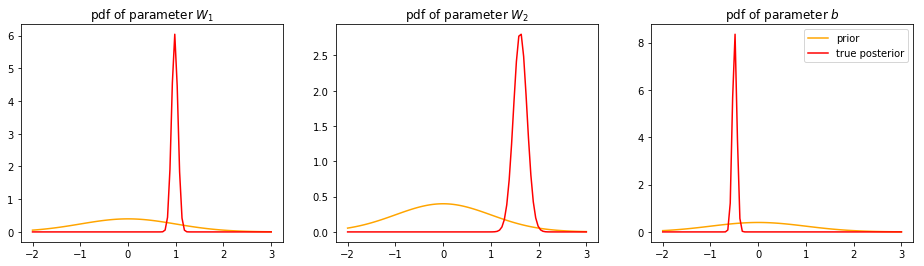

Correlation matrix between parameters (left: prior, right: posterior)


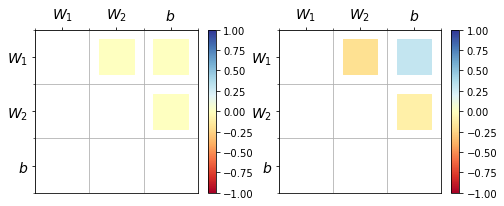

In [4]:
# define the problem
var_n = 0.1
w_true = [1., 1.7, -0.5]
f = lambda x, w, noisy: (w[0]*x[:, 0]+w[1]*x[:, 1]+w[2]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn_ = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([np.cos(xn_), 0.5*np.sin(xn_**2)], axis=1)
yn = f(xn, w_true, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
print(m_posterior)
print(np.sqrt(np.diag(S_posterior)))
print(S_posterior)
print('rho = {}'.format(S_posterior[1,2]/np.sqrt(S_posterior[1,1]*S_posterior[2,2])))
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter '+labels_params[p])
ax[2].legend()
plt.show(fig)

print('Correlation matrix between parameters (left: prior, right: posterior)')
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
plot_covariance_matrix(cov=cov_to_corr(S_prior), ax=ax[0], labels=labels_params)
plot_covariance_matrix(cov=cov_to_corr(S_posterior), ax=ax[1], labels=labels_params)
plt.show(fig)

In [5]:
# define the network
hidden_units = () # no hidden layers
prior_type = 'gaussian'
prior_params = (0., 1.) # only needed for output layer, for both kernels and biases
pre_model = None
kwargs = {'hidden_units': hidden_units, 'input_dim': 2, 'output_dim': 1, 'pre_model': pre_model, 'var_n': var_n,
         'prior_type': prior_type, 'prior_params': prior_params, 'activation': 'linear', 'weights_to_track': 'all'}

In the following we test several algorihtms and look at the posterior pdf (in particular uncertainty on parameter p2 should be smaller than uncertainty on parameter p0).

### Test BayesByBackprop

In [6]:
reg = BayesByBackprop(analytical_grads_bool=True, **kwargs)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=6000, lr=0.001)
#reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=500, lr=0.001)

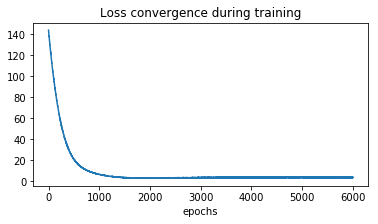

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


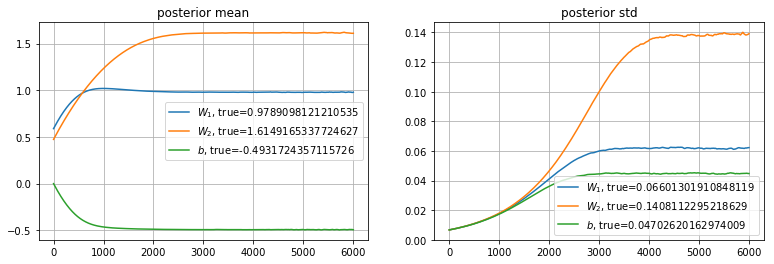

In [7]:
# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

In [8]:
corr = IScorrector(VI_regressor=reg, training_data=(xn, yn))
corr.fit(nsamples=5000)

Posterior mean for weights: 
[ 0.99303294  1.73921686 -0.56450736]
To be copmpared with true values:
[ 0.99197206  1.73756458 -0.56496534]
Marginal pdfs in all dimensions


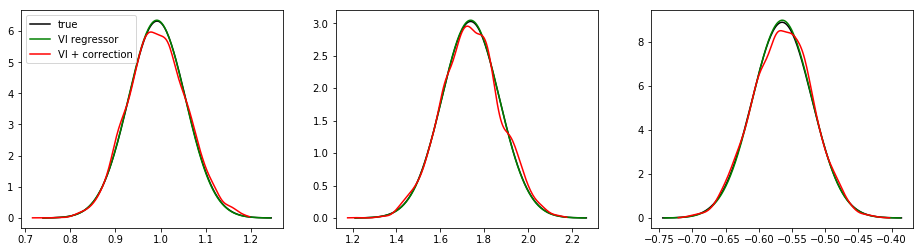

Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)


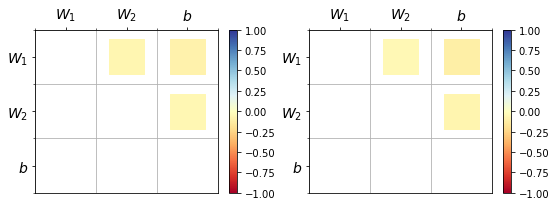

In [9]:
network_weights = corr.sample_all_weights(return_as_vector=True)
print('Posterior mean for weights: ')
print(np.mean(network_weights, axis=0))
print('To be copmpared with true values:')
print(m_posterior)
plot_marginals(m_posterior, S_posterior, reg, network_weights)
plot_corr(network_weights, S_posterior)

In [8]:
corr = MCMCcorrector(VI_regressor=reg, training_data=(xn, yn), algorithm='Stretch', nchains=20, method_='VI_sample')
corr.fit(nsamples_per_chain=200)

[array([[False],
       [False]]), array([False])]
[array([[False],
       [False]]), array([False])]
Tensor("add_15:0", shape=(?,), dtype=float32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0

Posterior mean for weights: 
[ 0.98797355  1.58988053 -0.49375479]
To be copmpared with true values:
[ 0.97890981  1.61491653 -0.49317244]
Marginal pdfs in all dimensions


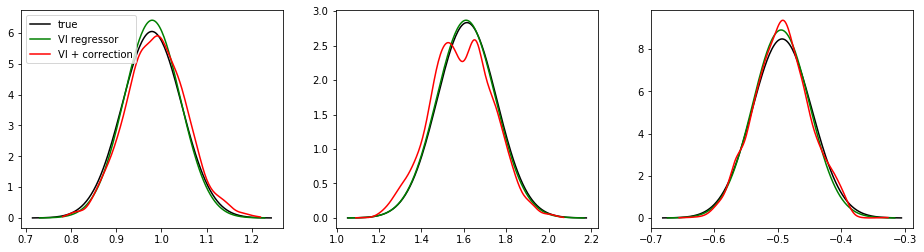

Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)


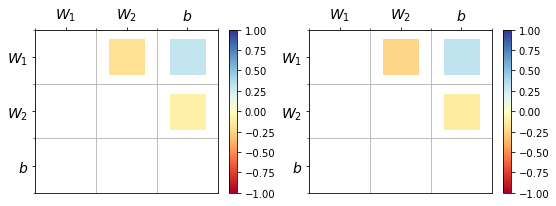

In [9]:
network_weights = corr.sample_all_weights(return_as_vector=True)
print('Posterior mean for weights: ')
print(np.mean(network_weights, axis=0))
print('To be copmpared with true values:')
print(m_posterior)
plot_marginals(m_posterior, S_posterior, reg, network_weights)
plot_corr(network_weights, S_posterior)

### Test alpha-BB algorithm

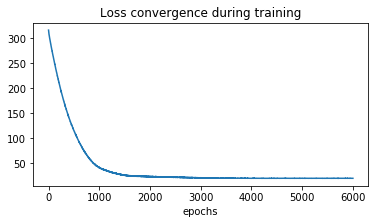

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


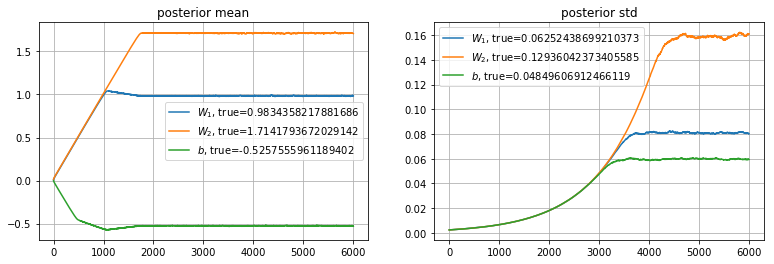

In [12]:
reg = alphaBB(**kwargs, alpha=0.5)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=6000, lr=0.001)
# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

## Second problem: the posterior pdf is Gaussian with dependent marginals

[ 1.0613129   1.58399597 -0.42008073]
[0.04717047 0.06851218 0.09171776]
[[ 2.22505280e-03 -3.04336544e-03 -9.78185637e-05]
 [-3.04336544e-03  4.69391884e-03 -1.71188627e-03]
 [-9.78185637e-05 -1.71188627e-03  8.41214753e-03]]


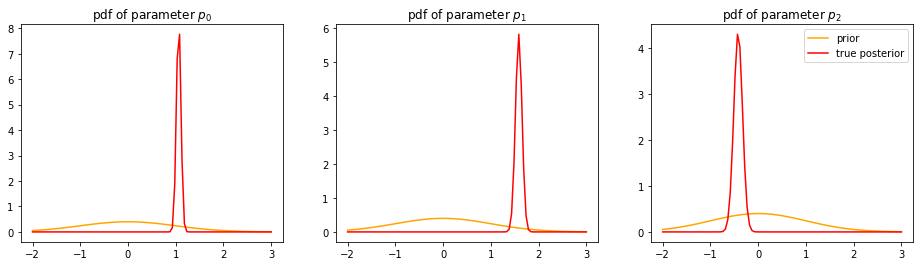

Correlation matrix between parameters (left: prior, right: posterior)


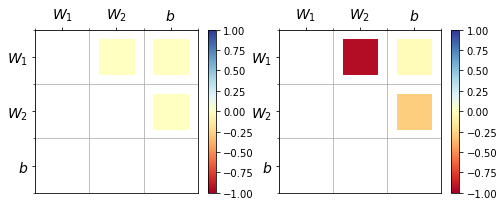

In [6]:
# define the problem
var_n = 0.1
w_true = [1., 1.7, -0.5]
f = lambda x, w, noisy: (w[0]*x[:, 0]+w[1]*x[:, 1]+w[2]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([xn, 0.7*xn+np.sin(xn)], axis=1)
yn = f(xn, w_true, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
print(m_posterior)
print(np.sqrt(np.diag(S_posterior)))
print(S_posterior)
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter $p_{}$'.format(p))
ax[2].legend()
plt.show(fig)

print('Correlation matrix between parameters (left: prior, right: posterior)')
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
plot_covariance_matrix(cov=cov_to_corr(S_prior), ax=ax[0], labels=labels_params)
plot_covariance_matrix(cov=cov_to_corr(S_posterior), ax=ax[1], labels=labels_params)
plt.show(fig)

# define the network
hidden_units = () # no hidden layers
prior_type = 'gaussian'
prior_params = (0., 1.) # only needed for output layer
pre_model = None
kwargs = {'hidden_units': hidden_units, 'input_dim': 2, 'output_dim': 1, 'pre_model': pre_model, 'var_n': var_n,
         'prior_type': prior_type, 'prior_params': prior_params, 'activation': 'linear', 'weights_to_track': 'all'}

### BayesByBackprop

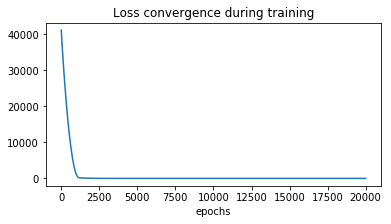

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


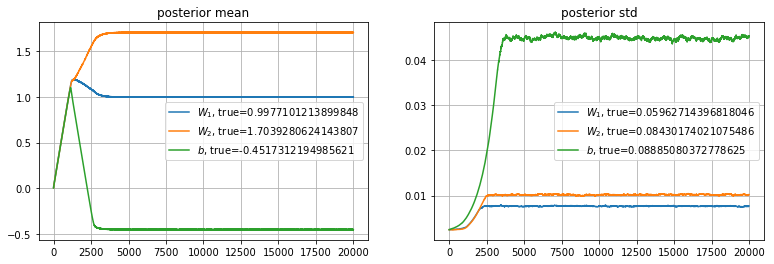

In [14]:
reg = BayesByBackprop(**kwargs)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=20000, lr=0.001)

# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

### alpha BB algorithm

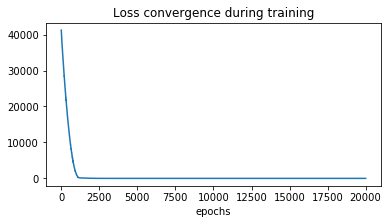

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


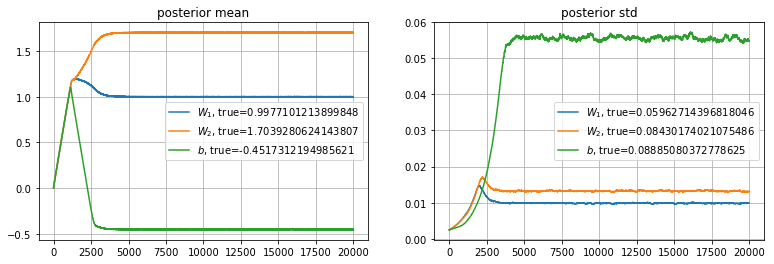

In [15]:
reg = alphaBB(**kwargs, alpha=0.5)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=20000, lr=0.001)

# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

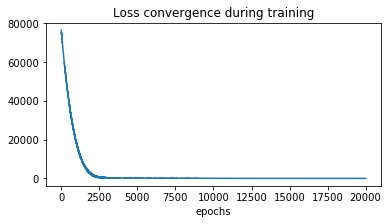

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


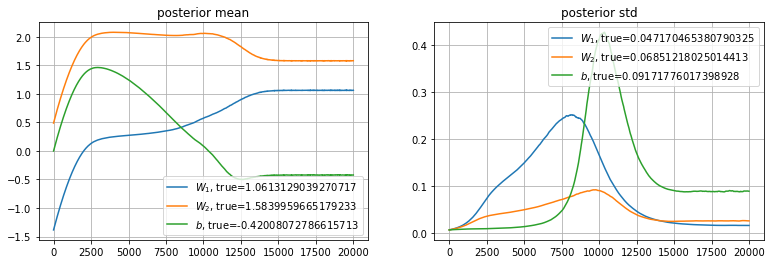

In [7]:
reg = alphaBB(**kwargs, alpha=0.99)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=20000, lr=0.001)

# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

## Use a corrector on that last regressor

[array([[ True],
       [ True]]), array([ True])]
[array([[ True],
       [ True]]), array([ True])]
Posterior mean for weights: 
[ 1.00537768  1.69516013 -0.45420826]
To be copmpared with true values:
[ 0.99771012  1.70392806 -0.45173122]
Marginal pdfs in all dimensions


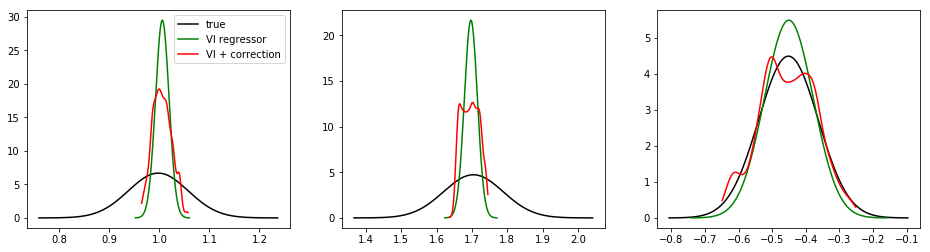

Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)


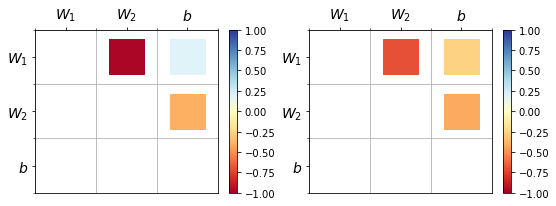

In [17]:
corr = IScorrector(VI_regressor=reg, training_data=(xn, yn))
corr.fit(nsamples=2000)

network_weights = corr.sample_all_weights(return_as_vector=True)
print('Posterior mean for weights: ')
print(np.mean(network_weights, axis=0))
print('To be copmpared with true values:')
print(m_posterior)
plot_marginals(m_posterior, S_posterior, reg, network_weights)
plot_corr(network_weights, S_posterior)

[array([[ True],
       [ True]]), array([ True])]
[array([[ True],
       [ True]]), array([ True])]
Posterior mean for weights: 
[ 1.00723803  1.69456206 -0.45991456]
To be copmpared with true values:
[ 0.99771012  1.70392806 -0.45173122]
Marginal pdfs in all dimensions


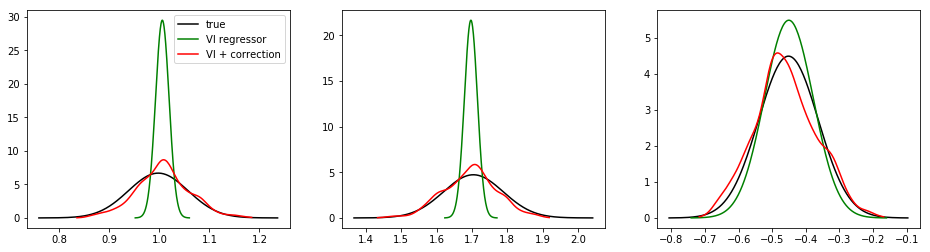

Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)


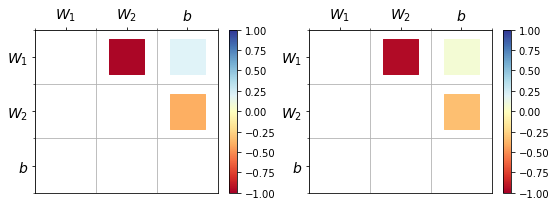

In [18]:
corr = MCMCcorrector(VI_regressor=reg, training_data=(xn, yn), algorithm='Stretch', nchains=20, method_='VI_mean')
corr.fit(nsamples_per_chain=100)

network_weights = corr.sample_all_weights(return_as_vector=True)
print('Posterior mean for weights: ')
print(np.mean(network_weights, axis=0))
print('To be copmpared with true values:')
print(m_posterior)
plot_marginals(m_posterior, S_posterior, reg, network_weights)
plot_corr(network_weights, S_posterior)

## Perform the correction only in the reduced space of {W1, W2}

In [9]:
mask_low_dim = [np.array([[True], [True]]), np.array([False, ])]
print(mask_low_dim[0])
print(mask_low_dim[1])

[[ True]
 [ True]]
[False]


[array([[ True],
       [ True]]), array([False])]
[array([[ True],
       [ True]]), array([ True])]
Posterior mean for weights: 
[ 1.0145359   1.682868   -0.45049056]
To be copmpared with true values:
[ 0.99771012  1.70392806 -0.45173122]
Marginal pdfs in all dimensions


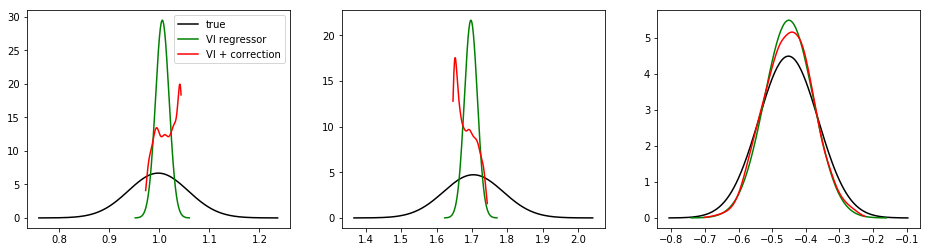

Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)


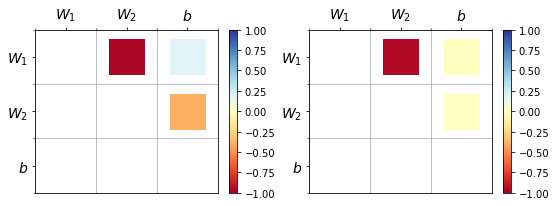

In [20]:
corr = IScorrector(VI_regressor=reg, training_data=(xn, yn), mask_low_dim=mask_low_dim)
corr.fit(nsamples=2000)

network_weights = corr.sample_all_weights(return_as_vector=True)
print('Posterior mean for weights: ')
print(np.mean(network_weights, axis=0))
print('To be copmpared with true values:')
print(m_posterior)
plot_marginals(m_posterior, S_posterior, reg, network_weights)
plot_corr(network_weights, S_posterior)

[array([[False],
       [False]]), array([ True])]
Tensor("add_25:0", shape=(?,), dtype=float32)
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294

[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1

[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1

[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1

[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1.4993294 1.4993294 1.4993294]
[1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294 1.4993294
 1

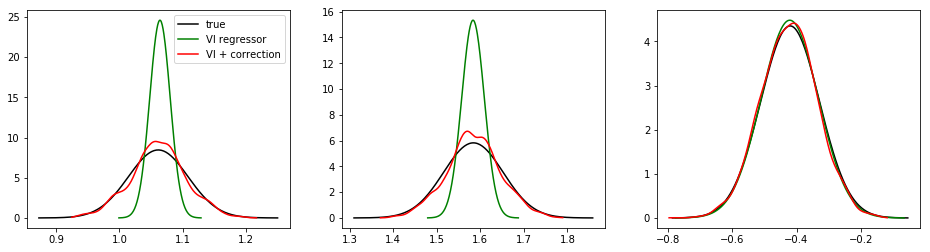

Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)


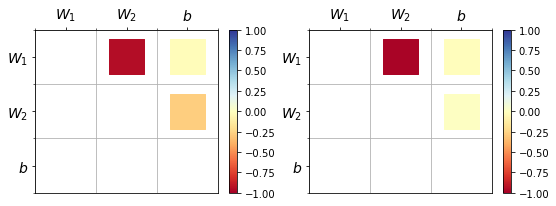

In [10]:
corr = MCMCcorrector(VI_regressor=reg, training_data=(xn, yn), mask_low_dim=mask_low_dim,
                    algorithm='Stretch', nchains=20, method_='VI_mean')
corr.fit(nsamples_per_chain=200)

network_weights = corr.sample_all_weights(return_as_vector=True)
print('Posterior mean for weights: ')
print(np.mean(network_weights, axis=0))
print('To be copmpared with true values:')
print(m_posterior)
plot_marginals(m_posterior, S_posterior, reg, network_weights)
plot_corr(network_weights, S_posterior)